# Danish garbage classification for recycling

### Imports

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import os

import cv2
from PIL import Image


from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import EfficientNetB0, ResNet50, MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix


from tensorflow import keras
from tensorflow.keras import layers, models

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten


import warnings
warnings.filterwarnings('ignore')

In [2]:
height = 256
width = 256
channels = 3

lr0005 = 0.0005
lr_001 = 0.001
lr005 = 0.005
lr05 = 0.05
lr_small = 1e-3

loss='categorical_crossentropy'

num_classes = 8

## Show images and inspect

In [3]:
class Images:
    def __init__(self, image_path):
        self.image_path = image_path
        self.garbage_types = []
        self._load_garbage_types() 

    def _load_garbage_types(self):
        for folder in os.listdir(self.image_path):
            folder_path = os.path.join(self.image_path, folder)
            if os.path.isdir(folder_path):
                self.garbage_types.append(folder)
            
    def load_image(self, folder_image):
        img = mpimg.imread(f'{self.image_path}{folder_image}')
        return img 
            
    def show_image(self, folder_image):
        img = mpimg.imread(f'{self.image_path}{folder_image}')
        plt.axis('off')
        plt.imshow(img)
        
        
    def show_multi_image(self, folder_path):
        path = f'{self.image_path}{folder_path}'
        image_files = [f for f in os.listdir(path=path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        fig, axes = plt.subplots(2,3, figsize=(15,10))
        axes = axes.flatten()
        
        for ax, img_file in zip(axes, image_files[:6]):
            img_path = os.path.join(path, img_file)
            img = mpimg.imread(img_path)
            ax.imshow(img)
            ax.set_title(img_file, fontsize=8)
            ax.axis("off")
        
        
        plt.tight_layout()
        fig.suptitle(folder_path, fontsize=20, y=1.03)
        plt.show()
        
        
    def folder_info(self):
        all_dimensions_set = set()
            
        for garbage_type in self.garbage_types:
            folder_path = os.path.join(self.image_path, garbage_type)
            
            # Verify that the current item is a directory
            if os.path.isdir(folder_path):
                image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
                
                # Display the count of images in the current folder
                num_images = len(image_files)
                print(f"{garbage_type} folder contains {num_images} images.")
                
                # Loop over each image to check its dimensions
                for image_file in image_files:
                    image_path = os.path.join(folder_path, image_file)
                    with Image.open(image_path) as img:
                        # Extract the width, height, and channels (color depth) of the image and add to the dimensions set
                        width, height = img.size
                        channels = len(img.getbands())
                        all_dimensions_set.add((width, height, channels))
        
             
        if len(all_dimensions_set) == 1: 
            width, height, channels = all_dimensions_set.pop()
            print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
        else:
            print("\nThe images in the dataset have different dimensions or color channels.")

In [4]:
path1_path = 'TrashType_Image_Dataset/'
path2_path = 'realwaste-main'

path1 = Images(path1_path)
path2 = Images(path2_path)

FileNotFoundError: [Errno 2] No such file or directory: 'TrashType_Image_Dataset/'

In [5]:
path1.show_image('cardboard/cardboard_254.jpg')

NameError: name 'path1' is not defined

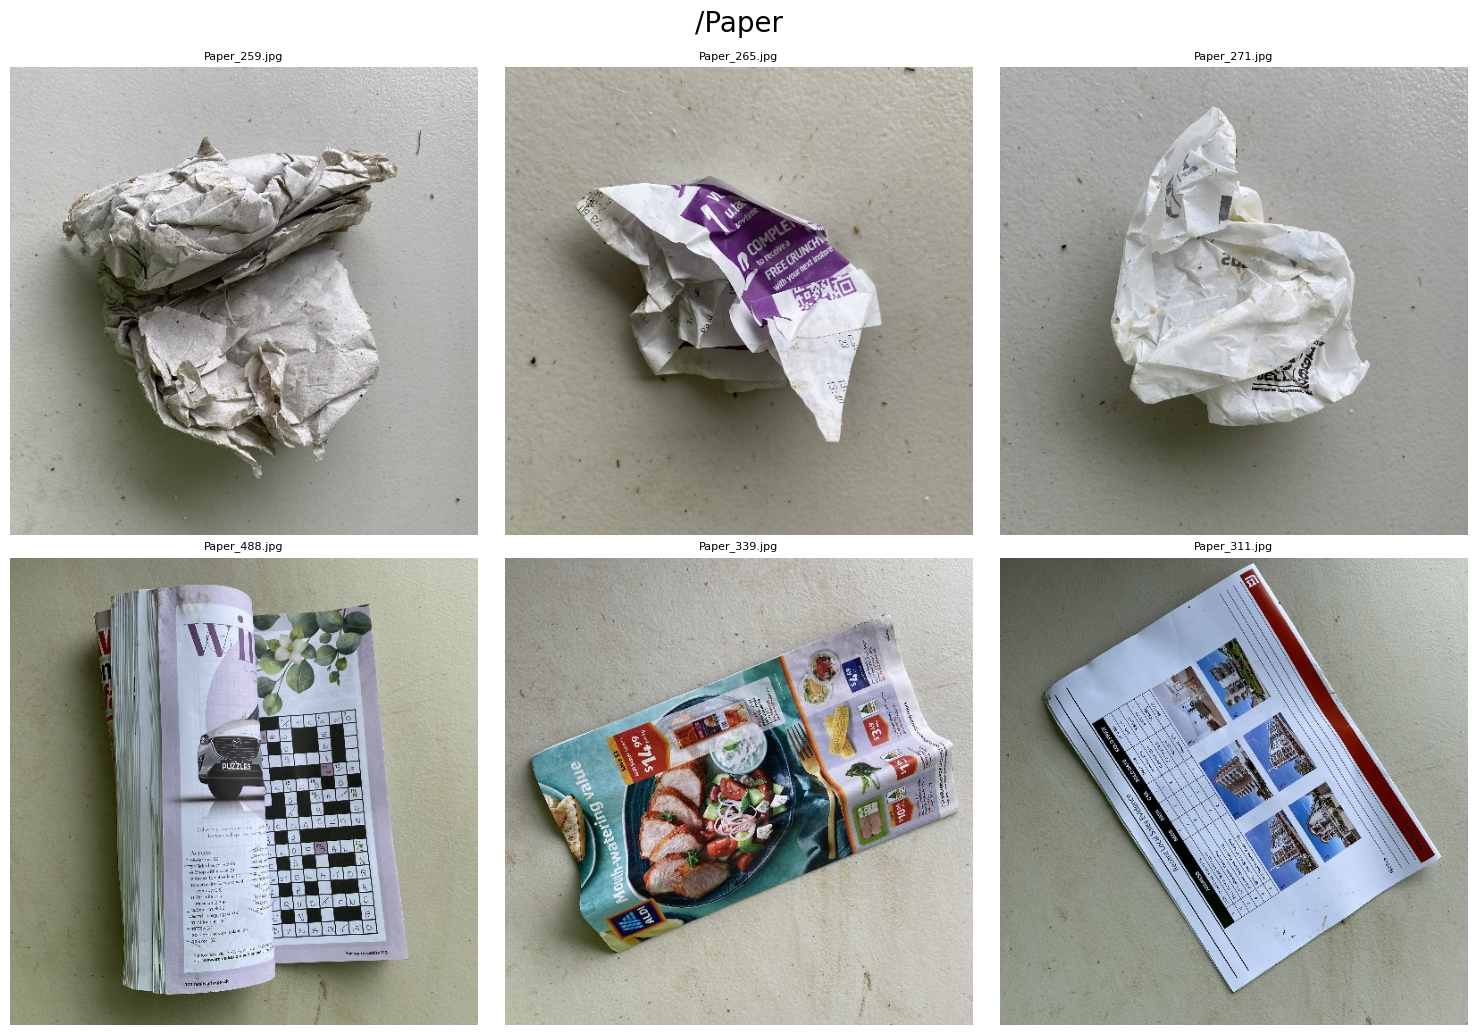

In [6]:
path2.show_multi_image('/Paper')

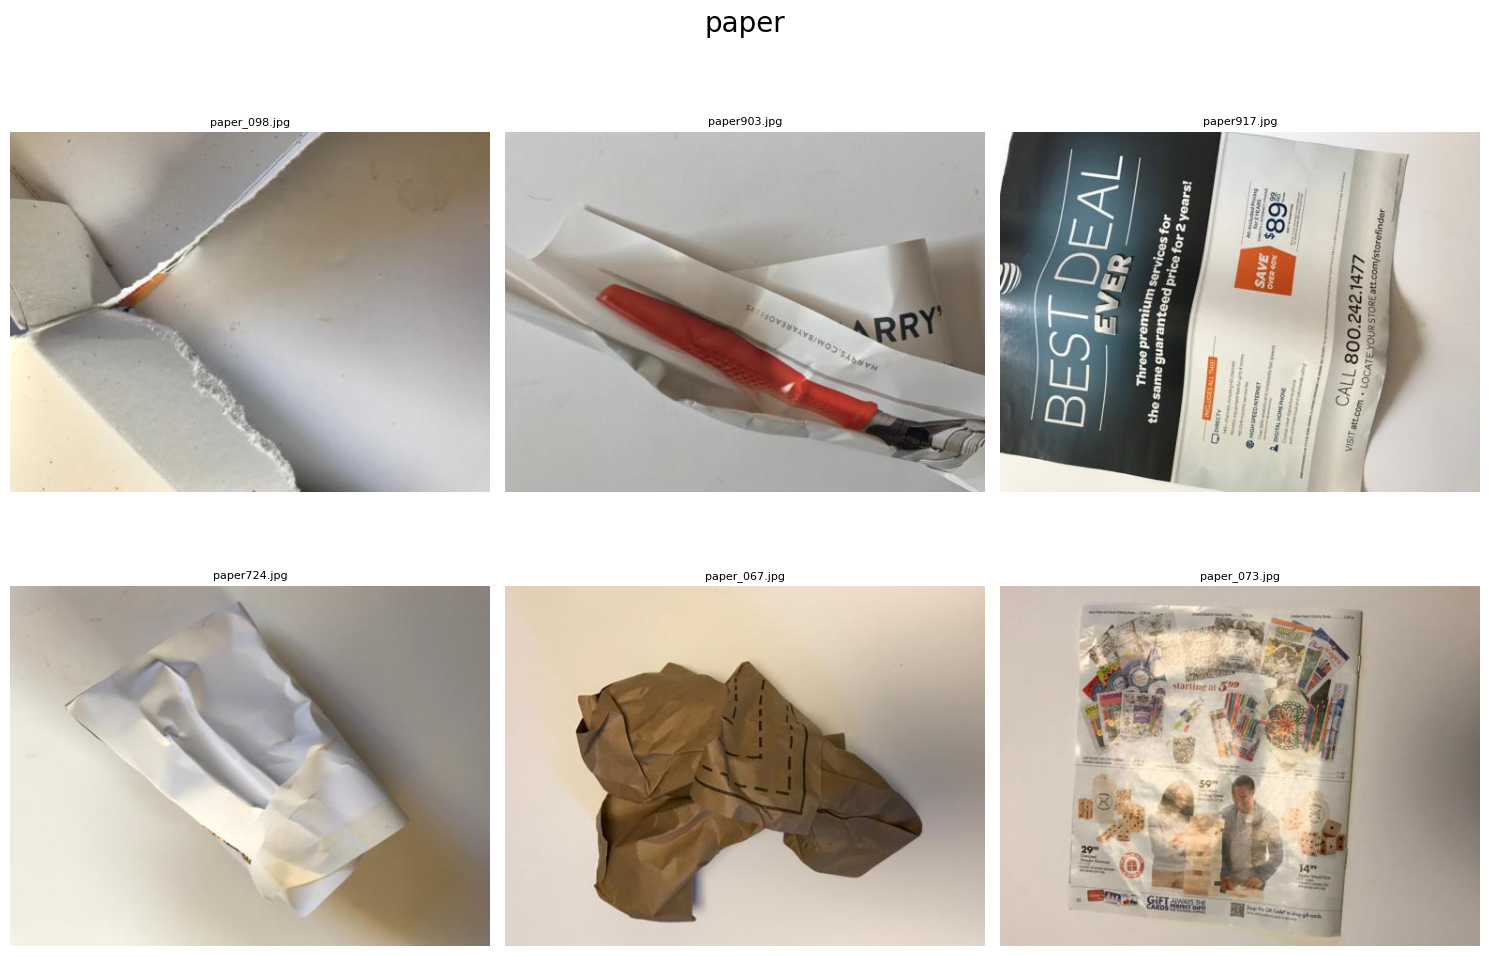

In [7]:
path1.show_multi_image('paper')

In [8]:
path1.folder_info()

paper folder contains 1152 images.
green-glass folder contains 622 images.
clothes folder contains 5325 images.
metal folder contains 1157 images.
cardboard folder contains 403 images.
trash folder contains 137 images.
glass folder contains 501 images.
brown-glass folder contains 607 images.
plastic folder contains 1198 images.
shoes folder contains 1977 images.

The images in the dataset have different dimensions or color channels.


In [9]:
path2.folder_info()

Paper folder contains 500 images.
Metal folder contains 790 images.
Cardboard folder contains 461 images.
Food Organics folder contains 411 images.
Glass folder contains 420 images.
Textile Trash folder contains 318 images.
Miscellaneous Trash folder contains 495 images.
Plastic folder contains 921 images.

All images in the dataset have the same dimensions: 524x524 with 3 color channels.


### Load and prepare data

In [10]:
class LoadImages():
    def __init__(self, path, intitial_path):
        self.path = path
        self.intitial_path = intitial_path
    def loade_to_df(self):
        data = []

        # Loop through each garbage type and collect its images' metadata
        for garbage_type in self.path.garbage_types:
            folder = os.path.join(self.intitial_path, garbage_type)
            for file in os.listdir(folder):
                filepath = os.path.join(folder, file)
                
#                try:
#                    # Load image (mpimg gives RGB, cv2 expects BGR)
#                    img = mpimg.imread(filepath)
#
#                    # Resize to (256, 256) - cv2 expects (width, height)
#                    img_resized = cv2.resize(img, (256, 256))
#
#                    # Ensure 3 channels
#                    if img_resized.ndim == 2:  # grayscale
#                        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
#                    elif img_resized.shape[2] == 4:  # RGBA → RGB
#                        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_RGBA2RGB)
#
#                    shape = img_resized.shape  # should now be (256, 256, 3)
#
#                except Exception as e:
#                    print(f"Skipping {filepath}, error: {e}")
#                    shape = None
#                    img_resized = None
#
#                # File size in bytes
#                size = os.path.getsize(filepath)
                data.append((filepath, garbage_type))


        df = pd.DataFrame(data, columns=['filepath', 'label'])
        return df

In [11]:
loader1 = LoadImages(path1, path1_path)
loader2 = LoadImages(path2,path2_path)

In [12]:
df1 = loader1.loade_to_df()
df2 = loader2.loade_to_df()

In [13]:
df = pd.concat([df1, df2], ignore_index=True)
df.head(10)

filepath  label
0  TrashType_Image_Dataset/paper/paper_098.jpg  paper
1   TrashType_Image_Dataset/paper/paper903.jpg  paper
2   TrashType_Image_Dataset/paper/paper917.jpg  paper
3   TrashType_Image_Dataset/paper/paper724.jpg  paper
4  TrashType_Image_Dataset/paper/paper_067.jpg  paper
5  TrashType_Image_Dataset/paper/paper_073.jpg  paper
6  TrashType_Image_Dataset/paper/paper_259.jpg  paper
7   TrashType_Image_Dataset/paper/paper526.jpg  paper
8   TrashType_Image_Dataset/paper/paper532.jpg  paper
9  TrashType_Image_Dataset/paper/paper_265.jpg  paper

In [14]:
class StatsPlotter():
    def __init__(self, df:pd.DataFrame):
        self.df = df
        
    def countplot(self, x_axis):
        vc_x = self.df['label'].value_counts()
        mean_x = vc_x.mean()
        ax = sns.countplot(self.df, x=x_axis, color='darkgreen', order=vc_x.index)
        ax.axhline(mean_x, ls='--', color='red', label=f'Mean = {mean_x:.1f}')
        ax.tick_params('x', rotation=45)
        ax.legend()
        plt.show()
    
    
    def df_info(self, column):
        vc_x = self.df[column].value_counts()
        mean_x = vc_x.mean()
        print(self.df[column].value_counts())
        print(f'The mean of the chosen column: {round(mean_x, 2)}')
        print('-'*50)
        print(self.df.info())

In [15]:
stats = StatsPlotter(df)

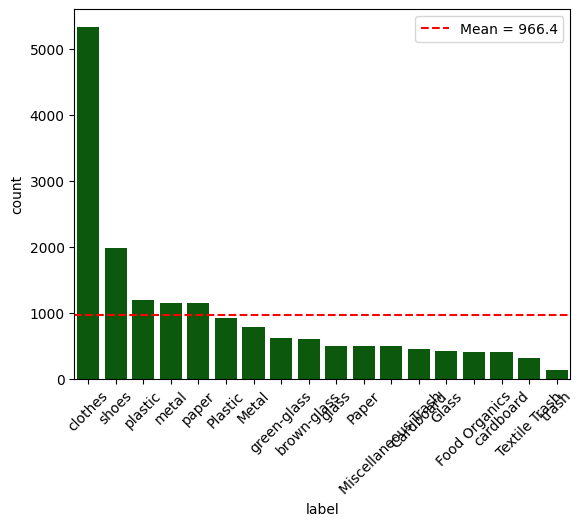

label
clothes                5325
shoes                  1977
plastic                1198
metal                  1157
paper                  1152
Plastic                 921
Metal                   790
green-glass             623
brown-glass             607
glass                   501
Paper                   500
Miscellaneous Trash     495
Cardboard               461
Glass                   420
Food Organics           411
cardboard               403
Textile Trash           318
trash                   137
Name: count, dtype: int64
The mean of the chosen column: 966.44
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17396 entries, 0 to 17395
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  17396 non-null  object
 1   label     17396 non-null  object
dtypes: object(2)
memory usage: 271.9+ KB
None


In [16]:
stats.countplot('label'),
stats.df_info('label')

# Preprocessing

### Affalds typer under https://www.ft.dk/samling/20222/almdel/kef/bilag/156/2670644.pdf
- Metal
- Papir
- Pap
- Glas
- Madaffald
- Restaffald
- Plastaffald
- Tekstilaffald
- Farligt affald

In [17]:
new_labels = {
    'clothes': 'Tekstilaffald',
    'Textile Trash' : 'Tekstilaffald',
    'shoes': 'Tekstilaffald',
    'paper': 'Papir',
    'Paper': 'Papir',
    'plastic': 'Plastaffald',
    'Plastic': 'Plastaffald',
    'cardboard': 'Pap',
    'Cardboard': 'Pap',
    'metal': 'Metal',
    'Metal': 'Metal',
    'biological': 'Madaffald',
    'Food Organics' : 'Madaffald',
    'battery': 'Farligt affald',
    'trash': 'Restaffald',
    'white-glass': 'Glas',
    'green-glass': 'Glas',
    'brown-glass': 'Glas',
    'glass': 'Glas',
    'Glass': 'Glas',
    'Miscellaneous Trash' : 'Restaffald'
}


In [18]:
df['label'] = df['label'].map(new_labels)
df.head(10)

filepath  label
0  TrashType_Image_Dataset/paper/paper_098.jpg  Papir
1   TrashType_Image_Dataset/paper/paper903.jpg  Papir
2   TrashType_Image_Dataset/paper/paper917.jpg  Papir
3   TrashType_Image_Dataset/paper/paper724.jpg  Papir
4  TrashType_Image_Dataset/paper/paper_067.jpg  Papir
5  TrashType_Image_Dataset/paper/paper_073.jpg  Papir
6  TrashType_Image_Dataset/paper/paper_259.jpg  Papir
7   TrashType_Image_Dataset/paper/paper526.jpg  Papir
8   TrashType_Image_Dataset/paper/paper532.jpg  Papir
9  TrashType_Image_Dataset/paper/paper_265.jpg  Papir

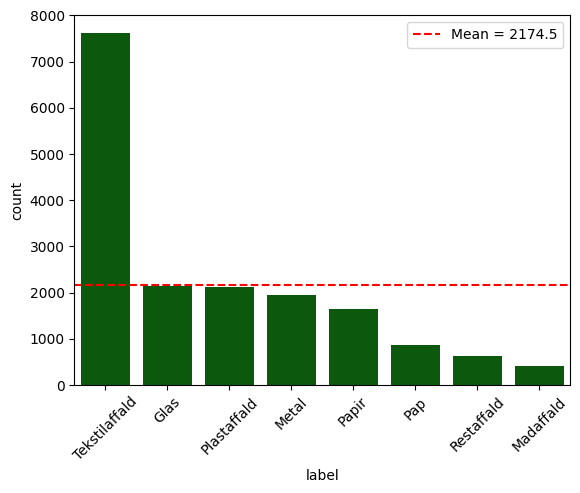

In [19]:
stats.countplot('label')

In [20]:
train_df, val_df = train_test_split(df,
                                    test_size=0.2,
                                    random_state=42,
                                    stratify=df['label'])

print(f'amount of images in train_df: {len(train_df)}')
print(f'amount of images in val_df: {len(val_df)}')

amount of images in train_df: 13916
amount of images in val_df: 3480


In [21]:
df_distribution = df['label'].value_counts(normalize=True) * 100
train_df_distribution = train_df['label'].value_counts(normalize=True) * 100
val_df_distribution = val_df['label'].value_counts(normalize=True) * 100


print("Class distribution in the entire dataset:\n")
print(df_distribution.round(2))
print('-'*40)

print("\nClass distribution in the training set:\n")
print(train_df_distribution.round(2))
print('-'*40)

print("\nClass distribution in the validation set:\n")
print(val_df_distribution.round(2))

Class distribution in the entire dataset:

label
Tekstilaffald    43.80
Glas             12.36
Plastaffald      12.18
Metal            11.19
Papir             9.50
Pap               4.97
Restaffald        3.63
Madaffald         2.36
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the training set:

label
Tekstilaffald    43.81
Glas             12.37
Plastaffald      12.18
Metal            11.19
Papir             9.49
Pap               4.97
Restaffald        3.64
Madaffald         2.36
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the validation set:

label
Tekstilaffald    43.79
Glas             12.36
Plastaffald      12.18
Metal            11.21
Papir             9.51
Pap               4.97
Restaffald        3.62
Madaffald         2.36
Name: proportion, dtype: float64


In [22]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0,1]
    rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.15,                    # Randomly zoom in or out by up to 15%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest'                 # Fill in missing pixels using the nearest filled value
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

In [23]:
# Generate training batches from the training dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(256, 256),              # Resize all images to size of 256x256
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=True                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(256, 256),              # Resize all images to size of 256x256
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

Found 13915 validated image filenames belonging to 8 classes.
Found 3480 validated image filenames belonging to 8 classes.


In [24]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 435
Number of batches in val_generator: 109


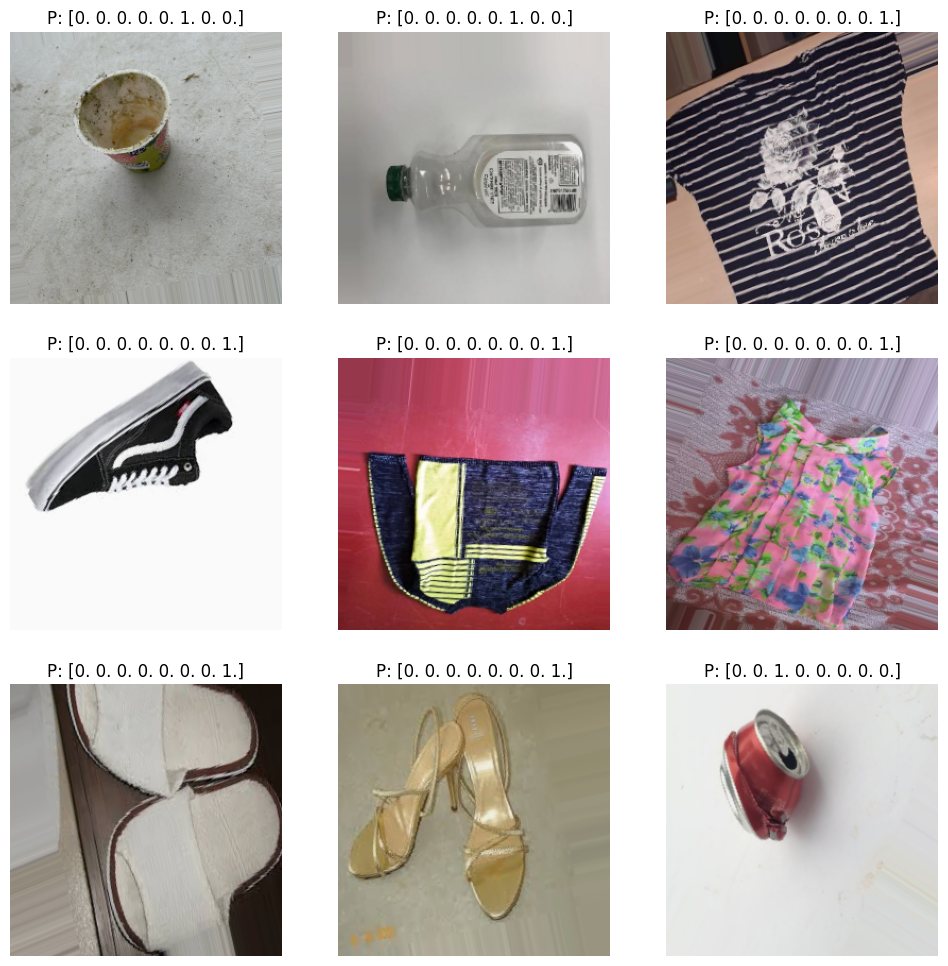

In [25]:
# Take a batch of images from the generator
images, labels = next(train_generator)

num_images = 9
plt.figure(figsize=(12, 12))
for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")
    plt.title(f"P: {labels[i]}", color='black')
plt.show()


In [26]:
class_indices = train_generator.class_indices
classes = np.unique(train_generator.classes)
print(class_indices)
# Compute the class weights
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_generator.classes
)

# Convert to dictionary: class index → weight
class_weights = dict(zip(classes, weights))
print(class_weights)

{'Glas': 0, 'Madaffald': 1, 'Metal': 2, 'Pap': 3, 'Papir': 4, 'Plastaffald': 5, 'Restaffald': 6, 'Tekstilaffald': 7}
{0: 1.011264534883721, 1: 5.286854103343465, 2: 1.1171323057161207, 3: 2.5171852387843705, 4: 1.3167108251324755, 5: 1.02617994100295, 6: 3.4375, 7: 0.2853305446194226}


# Model from scratch

In [27]:

def create_dataset_from_generator(generator):
    """Convert Keras generator to tf.data.Dataset"""
    def gen():
        for batch in generator:
            yield batch[0], batch[1]  # images, labels
    
    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 8), dtype=tf.float32)
        )
    )


# Create datasets
train_dataset = create_dataset_from_generator(train_generator)
val_dataset = create_dataset_from_generator(val_generator)

# Calculate steps per epoch
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

In [28]:
num_classes = 8

model = models.Sequential([
    # First convolutional block
    layers.Conv2D(32, (5,5), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Second convolutional block
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Third convolutional block
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # fourth convolutional block
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # GlobalAveragePooling2D layer instead of flatten
    layers.GlobalAveragePooling2D(),
    
    #Fully connected layers
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), # next 0.0005
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Print summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 252, 252, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 408,840 (1.56 MB)

 Trainable params: 407,880 (1.56 MB)

 Non-trainable params: 960 (3.75 KB)

In [29]:
import visualkeras
visualkeras.layered_view(model, legend=True).show()

In [59]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',  
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=7,
        min_lr=1e-6,
        verbose=1
    )
]

In [31]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    class_weight=class_weights,
    callbacks=callbacks,
    epochs=100,
    verbose=1
)

Epoch 1/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 572s 1s/step - accuracy: 0.3320 - loss: 1.9072 - val_accuracy: 0.2365 - val_loss: 2.1094 - learning_rate: 5.0000e-04
Epoch 2/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 589s 1s/step - accuracy: 0.4325 - loss: 1.5988 - val_accuracy: 0.3034 - val_loss: 1.8702 - learning_rate: 5.0000e-04
Epoch 3/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 576s 1s/step - accuracy: 0.4569 - loss: 1.4857 - val_accuracy: 0.3376 - val_loss: 1.6456 - learning_rate: 5.0000e-04
Epoch 4/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 603s 1s/step - accuracy: 0.4833 - loss: 1.4303 - val_accuracy: 0.4678 - val_loss: 1.6126 - learning_rate: 5.0000e-04
Epoch 5/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 616s 1s/step - accuracy: 0.4803 - loss: 1.4215 - val_accuracy: 0.4756 - val_loss: 1.4759 - learning_rate: 5.0000e-04
Epoch 6/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 606s 1s/step - accuracy: 0.5060 - loss: 1.3501 - val_accuracy: 0.4342 - val_loss: 2.0537 - learning_rate: 5.0000e-04
Epoch 7/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 623s 1s/ste

In [35]:
test_loss, test_acc = model.evaluate(val_generator, verbose=1)

print('\nTest accuracy:', round((test_acc),4))

109/109 ━━━━━━━━━━━━━━━━━━━━ 33s 303ms/step - accuracy: 0.6216 - loss: 1.0288

Test accuracy: 0.6305


# Plot models history - scratch

In [36]:
from matplotlib.colors import LinearSegmentedColormap
def evaluate_model_performance(model, val_generator, class_labels):
    
    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model  
    predictions = model.predict(val_generator, steps=len(val_generator))
    
    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    
    # Define a custom colormap
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()




def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
def plot_training_images(dataset, num_images=9):
    batch = next(iter(dataset))
    images, labels = batch
    
    fig, axes = plt.subplots(3,3, figsize=(10,10))
    axes = axes.ravel()
    
    for i in range(min(num_images, images.shape[0])):
                # Convert from tensor to numpy
        img = images[i].numpy()
        axes[i].imshow(img)
        
        class_idx = np.argmax(labels[i].numpy())
        axes[i].set_title(f'Class: {class_idx}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

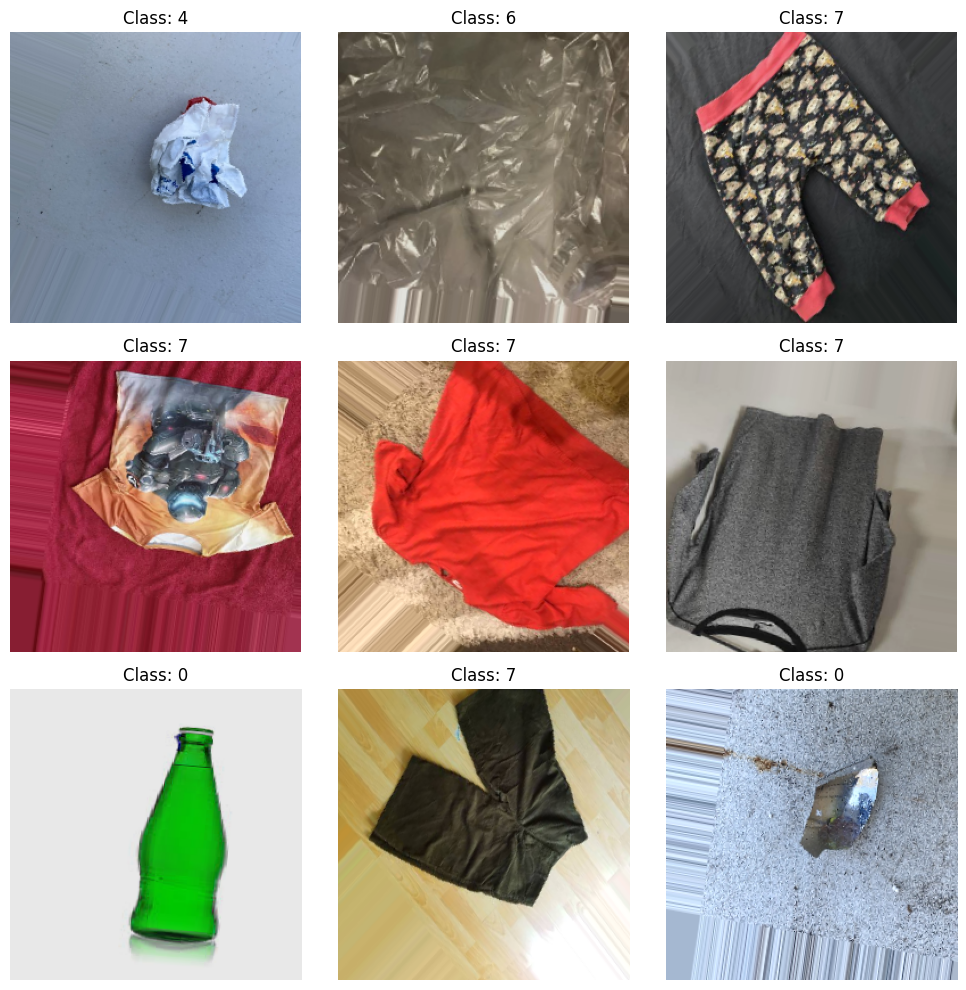

In [37]:
plot_training_images(train_dataset, 9)

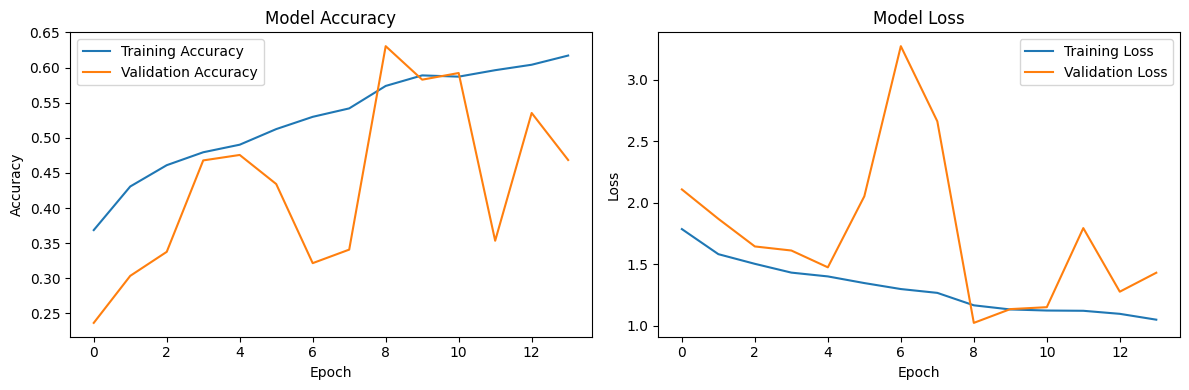

In [38]:
plot_training_history(history)

109/109 ━━━━━━━━━━━━━━━━━━━━ 34s 308ms/step
               precision    recall  f1-score   support

         Glas       0.72      0.50      0.59       430
    Madaffald       0.44      0.99      0.61        82
        Metal       0.51      0.53      0.52       390
          Pap       0.45      0.51      0.48       173
        Papir       0.50      0.51      0.51       331
  Plastaffald       0.42      0.62      0.50       424
   Restaffald       0.19      0.29      0.23       126
Tekstilaffald       0.91      0.75      0.82      1524

     accuracy                           0.63      3480
    macro avg       0.52      0.59      0.53      3480
 weighted avg       0.68      0.63      0.65      3480





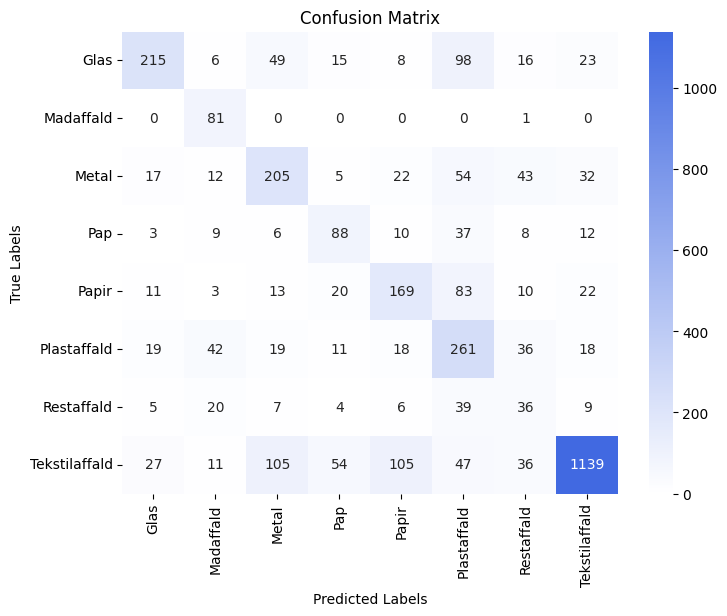

In [39]:
evaluate_model_performance(model, val_generator, class_indices)

# Transfer learning model

In [69]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, ResNet50, MobileNetV2, EfficientNetB5
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

### Small pretrained model

In [80]:
small_base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)
small_base_model.trainable = False  # 


small_model = models.Sequential([
    small_base_model,
    
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [81]:
small_model.compile(
    optimizer=Adam(learning_rate=lr_small),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [82]:
small_model_history = small_model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks,
    epochs=50,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/50
  6/435 ━━━━━━━━━━━━━━━━━━━━ 24:08 3s/step - accuracy: 0.1190 - loss: 2.1878

KeyboardInterrupt: 

In [ ]:
plot_training_history(small_model_history)

In [ ]:
evaluate_model_performance(small_model, val_generator, class_indices )

## Big pretrained model

In [ ]:
def create_pretrained_model(base_model='EfficientNetB0',
                            input_shape=(256,256,3),
                            num_classes=8,
                            freeze_base=False):
    
    
    
    base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=input_shape)
    
    base_model.trainable = not freeze_base
    print(f"{'Frozen' if freeze_base else 'Unfrozen'} base model (EfficientNetB0) with {len(base_model.layers)} layers")
    
    model = Sequential([
                    # First convolutional block
                    layers.Conv2D(32, (5,5), activation='relu', input_shape=(256, 256, 3)),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.BatchNormalization(),
                    layers.Dropout(0.2),

                    # Second convolutional block
                    layers.Conv2D(64, (3,3), activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.BatchNormalization(),
                    layers.Dropout(0.3),

                    # Third convolutional block
                    layers.Conv2D(128, (3,3), activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.BatchNormalization(),
                    layers.Dropout(0.3),
                    
                    # fourth convolutional block
                    layers.Conv2D(256, (3,3), activation='relu'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.BatchNormalization(),
                    layers.Dropout(0.3),

                    # GlobalAveragePooling2D layer instead of flatten
                    layers.GlobalAveragePooling2D(),
                    
                    #Fully connected layers
                    layers.Dense(64, activation='relu'),
                    layers.Dropout(0.5),

                    # Output layer
                    layers.Dense(num_classes, activation='softmax')
    ])
    return model, base_model


def compile_pretrained_model(model, lr=0.001):
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model
    

def create_callbacks(model_name):
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            patience=5,
            factor=0.2,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            model_name,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

In [ ]:

pt_model, base_model = create_pretrained_model(
    'EfficientNetB5',
    input_shape=(256,256,3),
    num_classes=8,
    freeze_base=True
)

pt_model = compile_pretrained_model(
    model=pt_model,
    lr=lr005
)

pt_callbakcs = create_callbacks('best_transfer_model.keras')

In [ ]:
pt_history = pt_model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=pt_callbakcs,
    class_weight=class_weights,
    epochs=50,
    verbose=1
)

# Plot result - transfer